<a href="https://colab.research.google.com/github/mehrarishab/image_classification/blob/main/Potato_Disease_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/datasets"

 covid_dataset	 COVID_IEEE   jobs.json   potato  'Untitled Jam.gjam'


In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
image_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "/content/drive/MyDrive/datasets/potato",
        shuffle=True,
        batch_size=32,
        image_size=(256, 256)
)

Found 2152 files belonging to 3 classes.


In [ ]:
class_names =  image_ds.class_names
class_names

['Early_blight', 'Late_blight', 'healthy']

In [ ]:
#Check the Lenght of the Dataset

len(image_ds) # This will effectively return the Number of batches entire dataset is split into


68

In [ ]:
# Check the type of the Dataset
type(image_ds)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

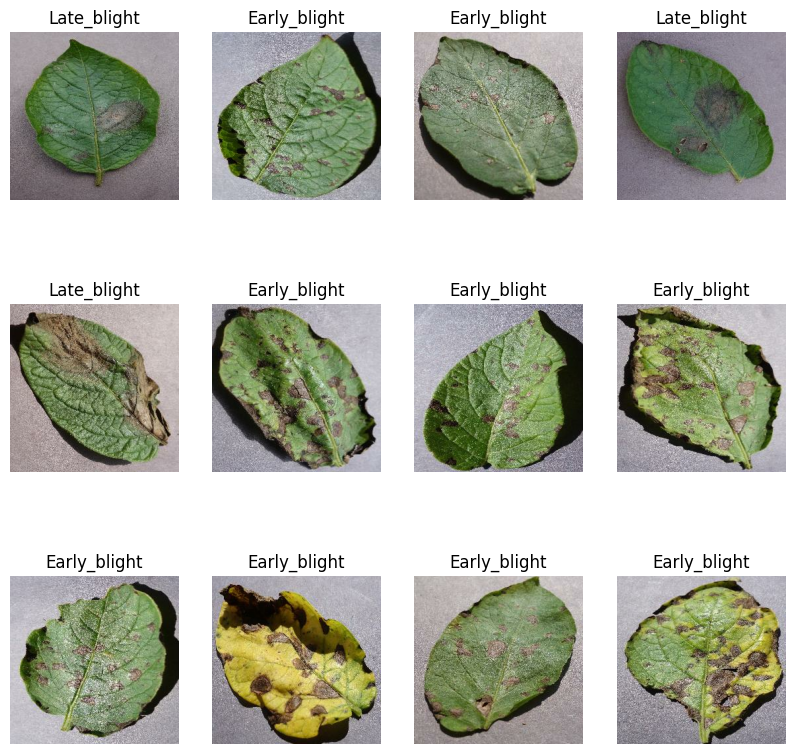

In [ ]:
# Explore the first batch
 #Here take is returning the entire Batch of 32 Images
plt.figure(figsize=(10, 10))

for img, label in image_ds.take(1):
  for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(img[i].numpy().astype("uint8"))
    plt.title(class_names[label[i]])
    plt.axis("off")




In [ ]:
train_size = int(len(image_ds) * 0.8)

# Split the Dataset in 80:20 ration

train_ds = image_ds.take(train_size)
test_ds = image_ds.skip(train_size)

print('Size of Train Dataset: ', len(train_ds))
print('Size of Test Dataset: ', len(test_ds))

Size of Train Dataset:  54
Size of Test Dataset:  14


In [ ]:
# Prepare validation Dataset

val_ds = train_ds.take(6)
train_ds = train_ds.skip(6)

print('Size of Train Dataset: ', len(train_ds))
print('Size of Validation Dataset: ', len(val_ds))
print('Size of Test Dataset: ', len(test_ds))

Size of Train Dataset:  48
Size of Validation Dataset:  6
Size of Test Dataset:  14


In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
  assert (train_split + test_split + val_split) == 1

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=42)

  train_ds = ds.take(int(train_split * len(ds))).skip(int(val_split * len(ds)))
  test_ds = ds.skip(int(train_split * len(ds)))
  val_ds = ds.take(int(train_split * len(ds))).take(int(val_split * len(ds)))

  return train_ds, val_ds, test_ds


In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(image_ds)

print('Size of Train Dataset: ', len(train_ds))
print('Size of Validation Dataset: ', len(val_ds))
print('Size of Test Dataset: ', len(test_ds))

Size of Train Dataset:  48
Size of Validation Dataset:  6
Size of Test Dataset:  14


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256,256),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2)
])

In [ ]:
# Building the model
image_size = 256
batch_size = 32
channels = 3
input_shape = (batch_size, image_size, image_size, channels)


model = tf.keras.Sequential([
    resize_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation='relu', input_shape=input_shape, kernel_initializer='he_normal'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,(3,3), activation='relu',  kernel_initializer='he_normal'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,(3,3), activation='relu',  kernel_initializer='he_normal'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,(3,3), activation='relu',kernel_initializer='he_normal'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,(3,3), activation='relu',kernel_initializer='he_normal'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,(3,3), activation='relu',kernel_initializer='he_normal'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten() ,
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

In [ ]:
model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
history =  model.fit(train_ds, epochs=30, batch_size=32, validation_data=val_ds, callbacks=[early_stopping], verbose=1)

Epoch 1/30
48/48 [==============================] - 496s 5s/step - loss: 0.9063 - accuracy: 0.5104 - val_loss: 0.7502 - val_accuracy: 0.6719
Epoch 2/30
48/48 [==============================] - 219s 5s/step - loss: 0.5742 - accuracy: 0.7487 - val_loss: 0.9108 - val_accuracy: 0.6510
Epoch 3/30
48/48 [==============================] - 222s 5s/step - loss: 0.3600 - accuracy: 0.8542 - val_loss: 1.4044 - val_accuracy: 0.7656
Epoch 4/30
48/48 [==============================] - 306s 6s/step - loss: 0.3416 - accuracy: 0.8529 - val_loss: 0.4110 - val_accuracy: 0.8542
Epoch 5/30
48/48 [==============================] - 276s 6s/step - loss: 0.2650 - accuracy: 0.8971 - val_loss: 0.3279 - val_accuracy: 0.8698
Epoch 6/30
48/48 [==============================] - 253s 5s/step - loss: 0.2253 - accuracy: 0.9121 - val_loss: 0.3086 - val_accuracy: 0.9010
Epoch 7/30
48/48 [==============================] - 263s 6s/step - loss: 0.2032 - accuracy: 0.9147 - val_loss: 0.2231 - val_accuracy: 0.9010
Epoch 8/30
48

In [ ]:
scores = model.evaluate(test_ds)

14/14 [==============================] - 25s 1s/step - loss: 0.1690 - accuracy: 0.9387


In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

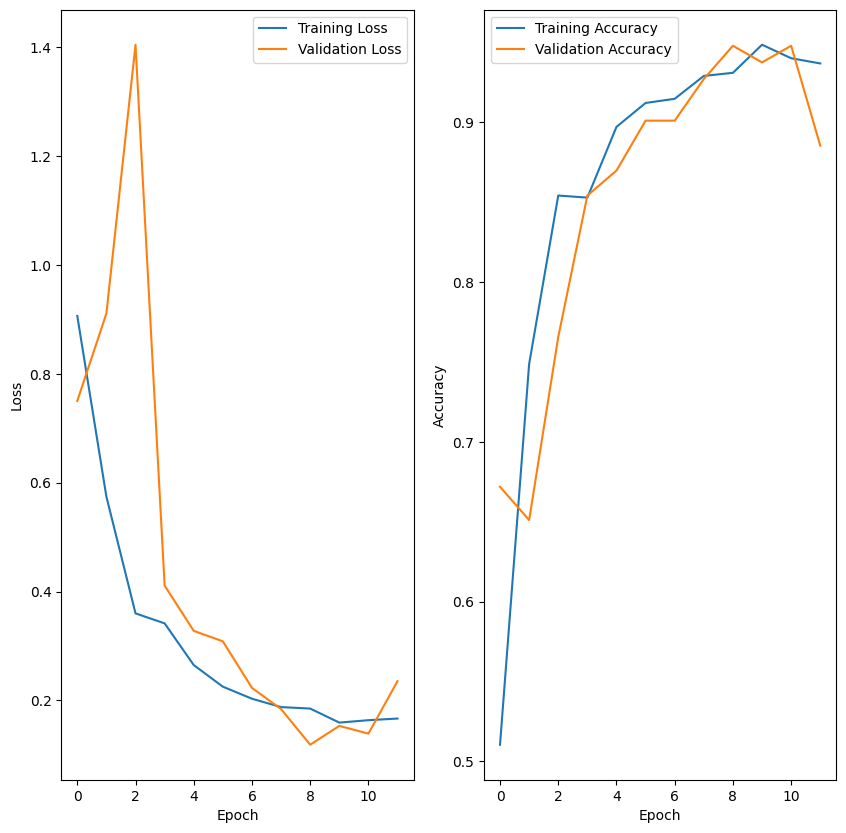

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
image_batch, label_batch = test_ds.as_numpy_iterator().next()

In [ ]:
len(image_batch),type(image_batch),len(label_batch),type(label_batch)

(32, numpy.ndarray, 32, numpy.ndarray)

1/1 [==============================] - 1s 1s/step


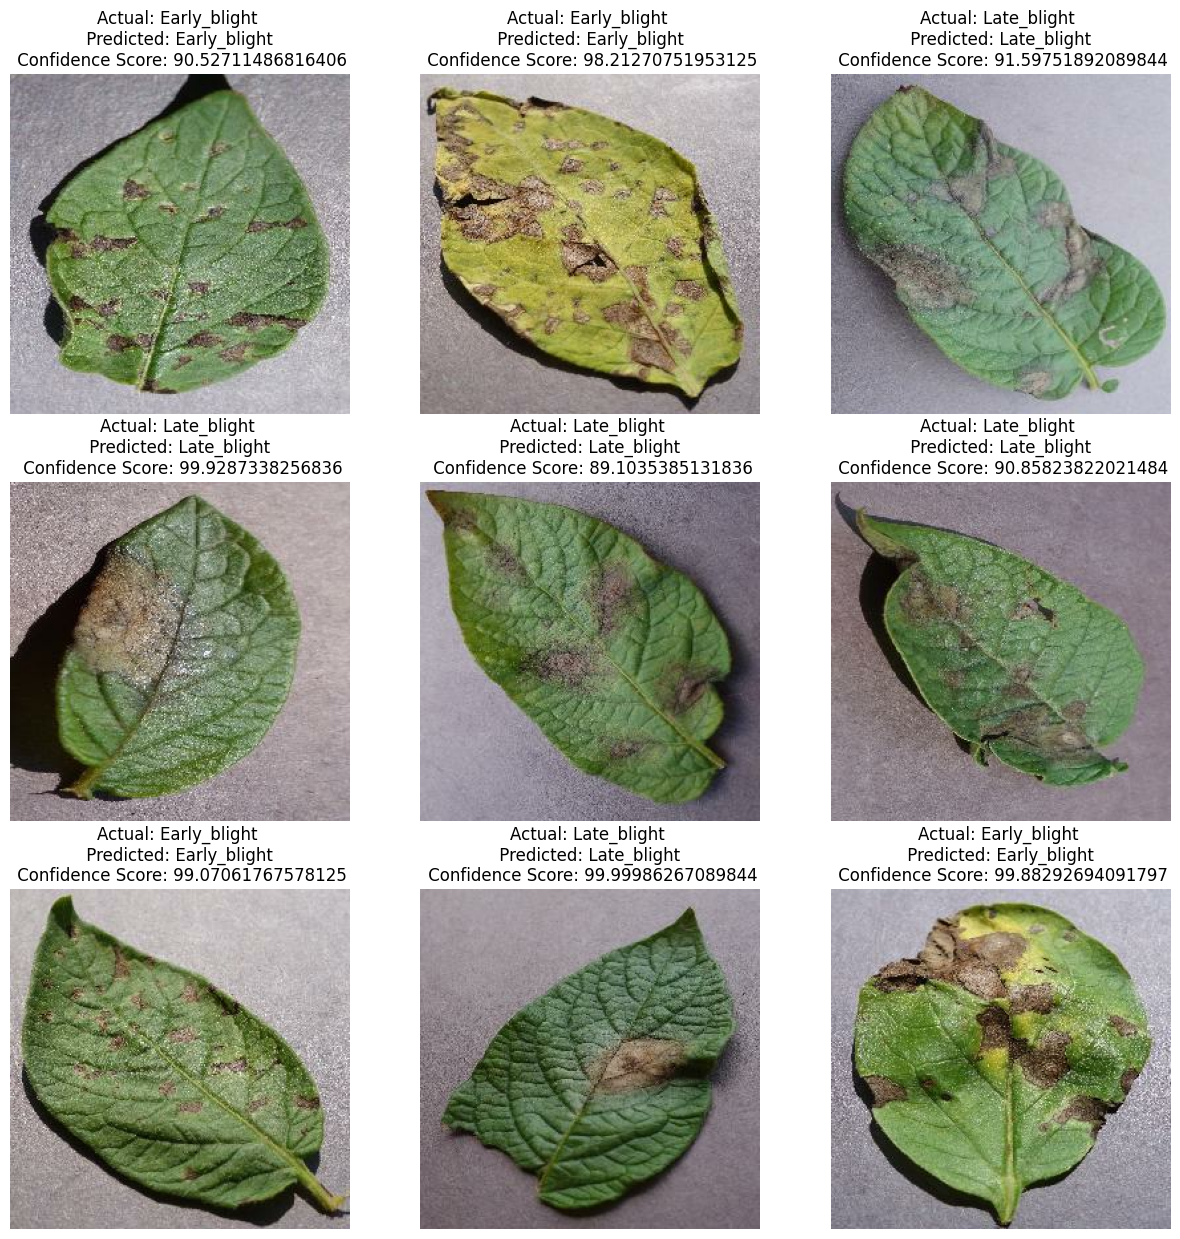

In [ ]:

prediction = model.predict(image_batch)
pred_class = np.argmax(prediction, axis=1)
confidences = (100 * np.max(prediction, axis=1))

plt.figure(figsize=(15,15))
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(image_batch[i].astype('uint8'))
  plt.title(f"Actual: {class_names[label_batch[i]]} \n Predicted: {class_names[pred_class[i]]} \n Confidence: {confidences[i]}")
  plt.axis('off')



In [ ]:
# Measure the Model Performance using confusion Matrix

from sklearn.metrics import confusion_matrix, classification_report
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

actuals = []
predictions = []
# The below loop for all 14 Batches for test data and total sample set would be 14 * batch_size
for image_batch, label_batch in test_ds.as_numpy_iterator():
  prediction = model.predict(image_batch)
  pred_class = np.argmax(prediction,axis=1)
  actuals.extend(label_batch)
  predictions.extend(pred_class)




In [ ]:
len(actuals),len(predictions)

(424, 424)

In [ ]:
print(classification_report(actuals,predictions))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       197
           1       0.97      0.90      0.93       197
           2       0.75      0.90      0.82        30

    accuracy                           0.94       424
   macro avg       0.89      0.93      0.91       424
weighted avg       0.94      0.94      0.94       424



In [ ]:
# Create Confusion Matrix
pd.DataFrame(confusion_matrix(actuals,predictions), index=class_names, columns=class_names)

,Early_blight,Late_blight,healthy
Early_blight,193,3,1
Late_blight,11,178,8
healthy,0,3,27


In [ ]:
import os

model_version = max([int(i) for i in os.listdir("/content/drive/MyDrive/models/potato_disease_classifier") + [0]]) + 1

model.save(f"/content/drive/MyDrive/models/potato_disease_classifier/{model_version}")